## Access Hydrological Observations

This notebook is used access hydrological data from the Meterological Services Canada API.
This is includes:
- Real time gauge data for discharge and water level
- Historic daily discharge
- Annual statistics for discharge and water level

It was developed using helpful, open access information provided by [MSC GeoMet services](https://eccc-msc.github.io/open-data/usage/use-case_oafeat/use-case_oafeat-script_en/).

In [10]:
# Import needed modules
import sys
import pandas as pd
from pathlib import Path
import yaml

# Import local scripts
sys.path.append('../scripts')
from plotting import plot_watershed_flowlines_stations
from scalar_data_access import retrieve_data_from_api
from hydrograph_plotting import plot_detailed_hydrograph
# Plot in notebook
%matplotlib inline

# Set up logger
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

#Suppress info from matplotlib
logging.getLogger('matplotlib.category').disabled = True

# add autoreload to automatically reload modules when they change
%load_ext autoreload
%autoreload 2

### Read settings configuration file

In [11]:
config_file = "../settings/general_settings.yaml"

# Read settings from yaml file
with open(config_file, 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)

# Set variables, this can be replaced by a config file. To be discussed
api_url = config['msc_open_data_settings']['api_url']

# Set up paths 
gis_data_dir = config['paths']['gis_data']
output_dir = Path(config['paths']['output_dir'])
output_dir.mkdir(parents=True, exist_ok=True)

# Set up paths to gis data
stations_csv = Path(gis_data_dir, config['gis_data']['hydro_stns_csv'])
watershed_shp = Path(gis_data_dir, config['gis_data']['basins_shp'])
flowlines_shp = Path(gis_data_dir, config['gis_data']['flowlines_shp'])


### Plot watersheds and stations

<urlopen error [Errno 8] nodename nor servname provided, or not known><urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>

<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>


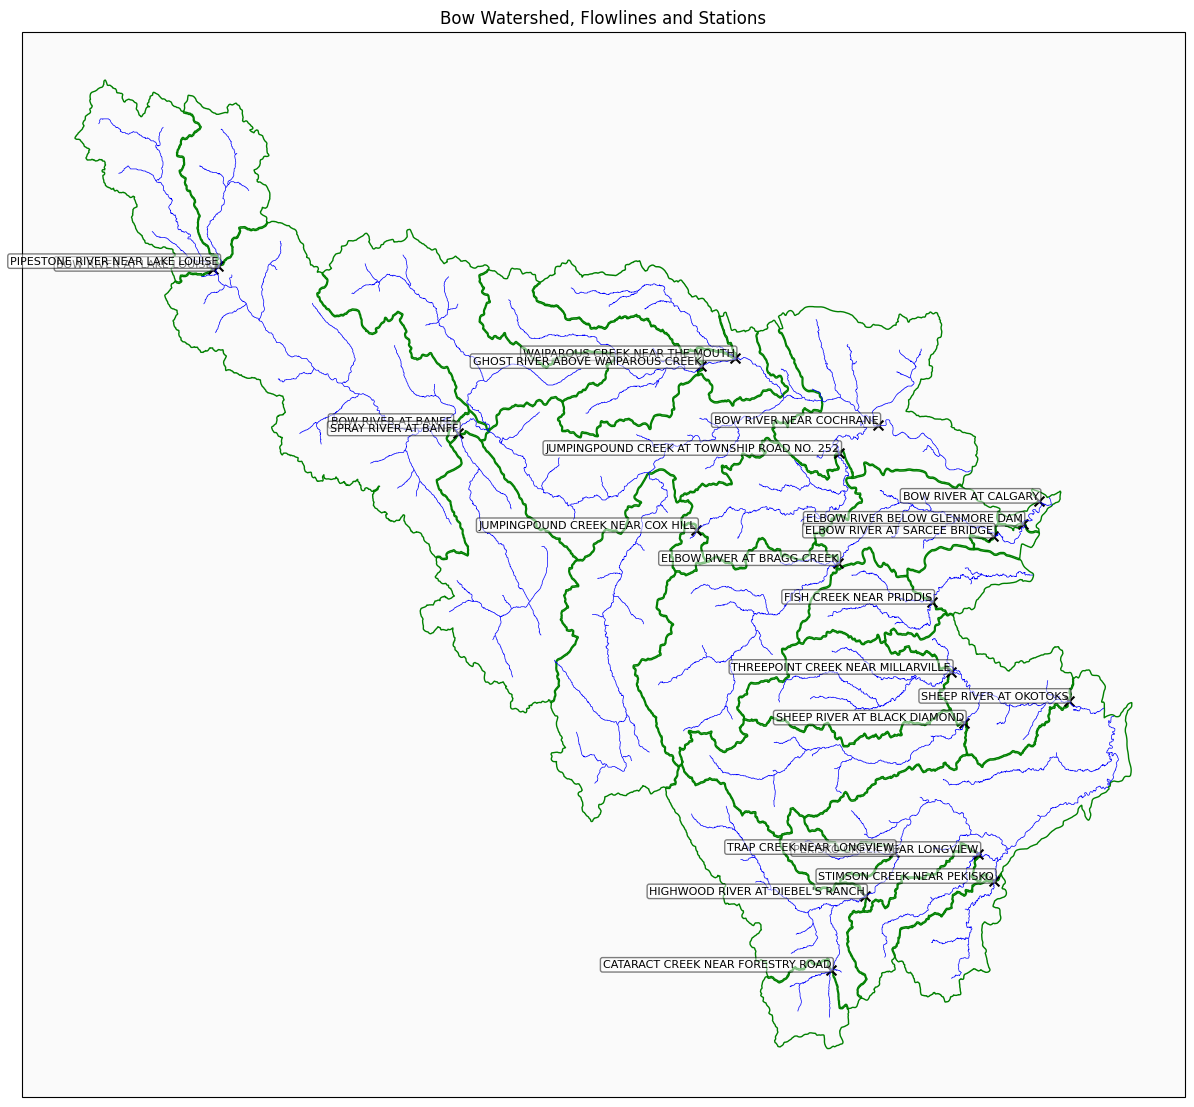

In [6]:
plot_watershed_flowlines_stations(watershed_shp, flowlines_shp, stations_csv)

## Define stations to be imported

Hydrometric station data can be accessed and downloaded.
This is for near real time data as well as historic record.

In this notebook, the stations are read from a provided csv file.
This could be substituted with any list of stations. Station information can also be pulled from the MSC API.

In [12]:
# Read in the list of hydrometric stations
hydro_stations_df = pd.read_csv(stations_csv)
search_stations = hydro_stations_df["ID"].tolist()

logger.info(f'Search stations: {hydro_stations_df}')

INFO:__main__:Search stations:          ID                                   Name / Nom  Latitude  Longitude  \
0   05BA001                     BOW RIVER AT LAKE LOUISE  51.42860 -116.18894   
1   05BA002             PIPESTONE RIVER NEAR LAKE LOUISE  51.43311 -116.17495   
2   05BB001                           BOW RIVER AT BANFF  51.17223 -115.57177   
3   05BC001                         SPRAY RIVER AT BANFF  51.16018 -115.55447   
4   05BG006               WAIPAROUS CREEK NEAR THE MOUTH  51.28281 -114.83841   
5   05BG010            GHOST RIVER ABOVE WAIPAROUS CREEK  51.27003 -114.92553   
6   05BH004                         BOW RIVER AT CALGARY  51.05027 -114.05146   
7   05BH005                      BOW RIVER NEAR COCHRANE  51.17374 -114.46643   
8   05BH013             JUMPINGPOUND CREEK NEAR COX HILL  51.00233 -114.93814   
9   05BH015  JUMPINGPOUND CREEK AT TOWNSHIP ROAD NO. 252  51.12831 -114.56750   
10  05BJ001               ELBOW RIVER BELOW GLENMORE DAM  51.01279 -114.09320 

### Download Real Time Hydrometric Data 

In [18]:
collection = 'hydrometric-realtime'
datetime_column = "DATETIME"

download_variable = "DISCHARGE"
real_time_discharge_stations = retrieve_data_from_api(search_stations, collection, download_variable, datetime_column, api_url, output_dir)

download_variable = "LEVEL"
real_time_level_stations = retrieve_data_from_api(search_stations, collection, download_variable, datetime_column, api_url, output_dir)


INFO:scalar_data_access:Retrieving DISCHARGE from hydrometric-realtime with no time limits
INFO:scalar_data_access:Query variables: ['STATION_NUMBER', 'STATION_NAME', 'DATETIME', 'DISCHARGE']
INFO:scalar_data_access:Output directory: ../data_output/hydrometric-realtime
INFO:scalar_data_access:DISCHARGE from hydrometric-realtime for station 05BA002 output to ../data_output/hydrometric-realtime/05BA002_DISCHARGE.csv
INFO:scalar_data_access:DISCHARGE from hydrometric-realtime for station 05BB001 output to ../data_output/hydrometric-realtime/05BB001_DISCHARGE.csv
INFO:scalar_data_access:DISCHARGE from hydrometric-realtime for station 05BC001 output to ../data_output/hydrometric-realtime/05BC001_DISCHARGE.csv
INFO:scalar_data_access:DISCHARGE from hydrometric-realtime for station 05BG006 output to ../data_output/hydrometric-realtime/05BG006_DISCHARGE.csv
INFO:scalar_data_access:DISCHARGE from hydrometric-realtime for station 05BG010 output to ../data_output/hydrometric-realtime/05BG010_DISC

### Download Historic Daily Mean Data

In [21]:
collection = 'hydrometric-daily-mean'
datetime_column = "DATE"

download_variable = "DISCHARGE"
other_variables = ['DISCHARGE_SYMBOL_EN']
historic_discharge_stations = retrieve_data_from_api(search_stations, collection, download_variable, datetime_column, api_url, output_dir,other_variables)

download_variable = "LEVEL"
other_variables = ['LEVEL_SYMBOL_EN']
historic_level_stations = retrieve_data_from_api(search_stations, collection, download_variable, datetime_column, api_url, output_dir,other_variables)

INFO:scalar_data_access:Retrieving DISCHARGE from hydrometric-daily-mean with no time limits
INFO:scalar_data_access:Query variables: ['STATION_NUMBER', 'STATION_NAME', 'DATE', 'DISCHARGE', 'DISCHARGE_SYMBOL_EN']
INFO:scalar_data_access:Output directory: ../data_output/hydrometric-daily-mean
INFO:scalar_data_access:DISCHARGE from hydrometric-daily-mean for station 05BA001 output to ../data_output/hydrometric-daily-mean/05BA001_DISCHARGE.csv
INFO:scalar_data_access:DISCHARGE from hydrometric-daily-mean for station 05BA002 output to ../data_output/hydrometric-daily-mean/05BA002_DISCHARGE.csv
INFO:scalar_data_access:DISCHARGE from hydrometric-daily-mean for station 05BB001 output to ../data_output/hydrometric-daily-mean/05BB001_DISCHARGE.csv
INFO:scalar_data_access:DISCHARGE from hydrometric-daily-mean for station 05BC001 output to ../data_output/hydrometric-daily-mean/05BC001_DISCHARGE.csv
INFO:scalar_data_access:DISCHARGE from hydrometric-daily-mean for station 05BG006 output to ../data

### Download Annual Statistics

In [25]:

collection = 'hydrometric-annual-statistics'

datetime_column='MAX_DATE'
download_variable = 'MAX_VALUE'
other_variables = ['MAX_SYMBOL_EN']
max_annual_stations = retrieve_data_from_api(search_stations, collection, download_variable, datetime_column, api_url, output_dir,other_variables)

datetime_column='MIN_DATE'
download_variable = 'MIN_VALUE'
other_variables = ['MIN_SYMBOL_EN']
min_annual_stations = retrieve_data_from_api(search_stations, collection, download_variable, datetime_column, api_url, output_dir,other_variables)


INFO:scalar_data_access:Retrieving MAX_VALUE from hydrometric-annual-statistics with no time limits
INFO:scalar_data_access:Query variables: ['STATION_NUMBER', 'STATION_NAME', 'MAX_DATE', 'MAX_VALUE', 'MAX_SYMBOL_EN']
INFO:scalar_data_access:Output directory: ../data_output/hydrometric-annual-statistics


INFO:scalar_data_access:MAX_VALUE from hydrometric-annual-statistics for station 05BA001 output to ../data_output/hydrometric-annual-statistics/05BA001_MAX_VALUE.csv
INFO:scalar_data_access:MAX_VALUE from hydrometric-annual-statistics for station 05BA002 output to ../data_output/hydrometric-annual-statistics/05BA002_MAX_VALUE.csv
INFO:scalar_data_access:MAX_VALUE from hydrometric-annual-statistics for station 05BB001 output to ../data_output/hydrometric-annual-statistics/05BB001_MAX_VALUE.csv
INFO:scalar_data_access:MAX_VALUE from hydrometric-annual-statistics for station 05BC001 output to ../data_output/hydrometric-annual-statistics/05BC001_MAX_VALUE.csv
INFO:scalar_data_access:MAX_VALUE from hydrometric-annual-statistics for station 05BG006 output to ../data_output/hydrometric-annual-statistics/05BG006_MAX_VALUE.csv
INFO:scalar_data_access:MAX_VALUE from hydrometric-annual-statistics for station 05BG010 output to ../data_output/hydrometric-annual-statistics/05BG010_MAX_VALUE.csv
INFO

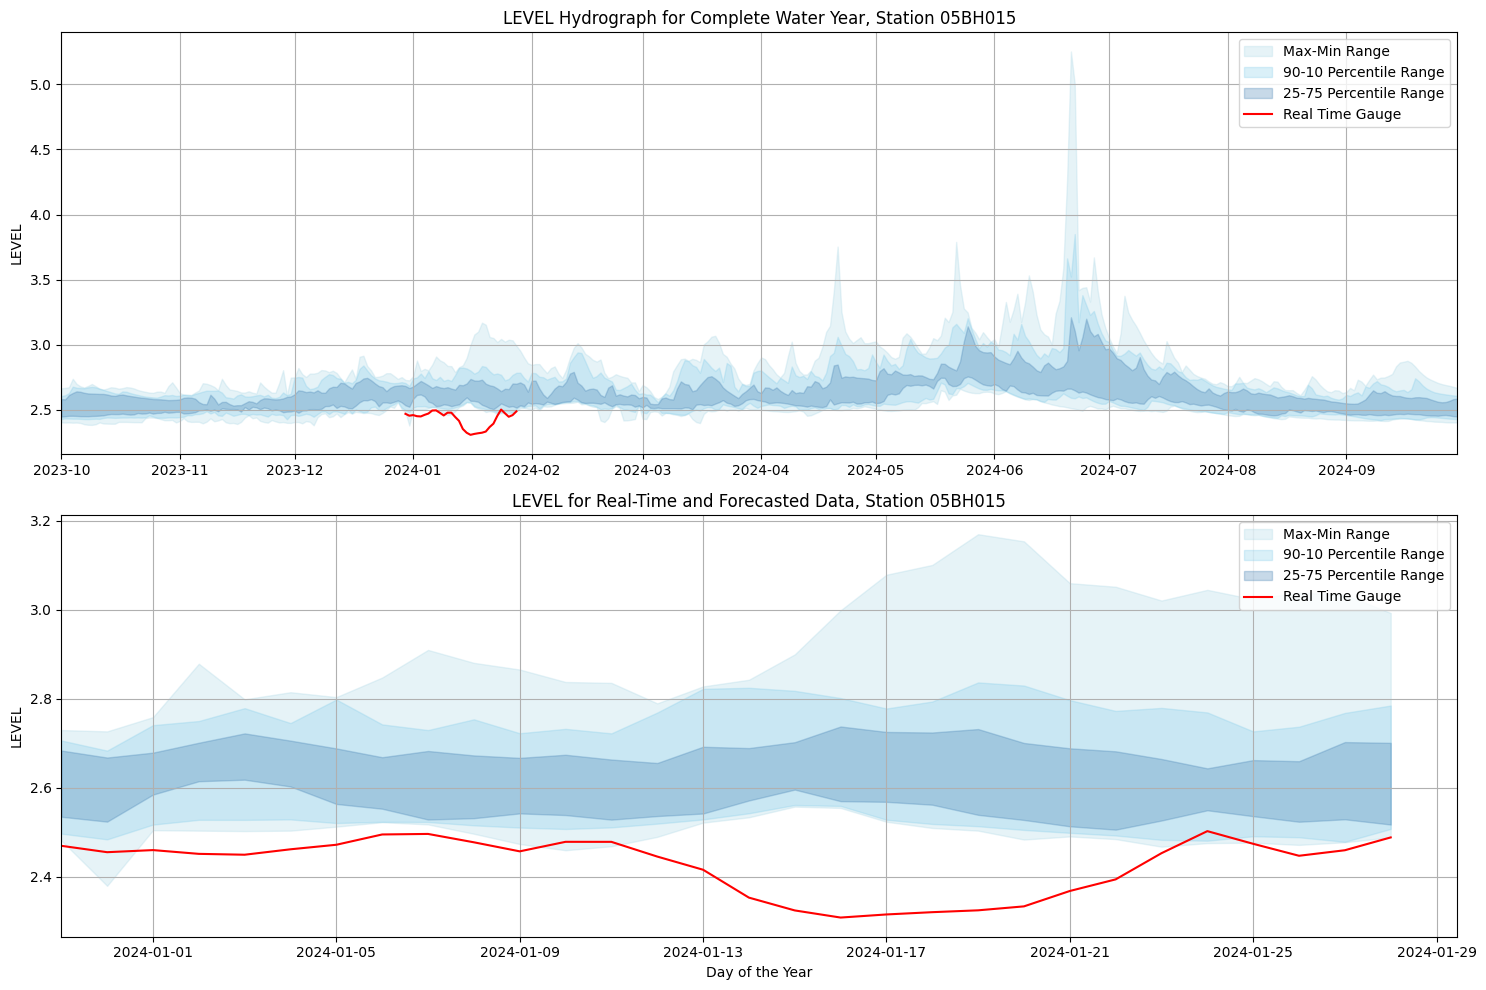

In [13]:
variable = 'LEVEL'

real_time_level_stations = ['05BH015']
historic_level_stations = ['05BH015']

#print(f'Real time stations with {variable} data: {real_time_discharge_stations}')

for station_id in real_time_level_stations:
    if station_id not in historic_level_stations:
        continue
    
    historic_df = pd.read_csv(f'{output_dir}/hydrometric-daily-mean/{station_id}_{variable}.csv')
    realtime_df = pd.read_csv(f'{output_dir}/hydrometric-realtime/{station_id}_{variable}.csv')
    png_path = f'{output_dir}/{station_id}_{variable}_hydrograph.png'

    plot_detailed_hydrograph(station_id,variable, historic_df, realtime_df, save_png=True, png_path=png_path)